In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os

In [2]:
Image_Size = 256
Batch_Size = 32
Channels = 3
Epochs = 20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
batch_size=Batch_Size,
image_size=(Image_Size,Image_Size),
shuffle=True)

Found 2153 files belonging to 3 classes.


In [4]:
class_name=dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [7]:
for image_batch, labels_batch in dataset.take(2):#dataset.take(n)--->n of batch
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 2 0 1 0 1 1 2 0 1 1 0 1 0 0 0 1 2 2 0 0 1 0 0 1 1 1 0 0 0 1]
(32, 256, 256, 3)
[0 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 2 1 1 1 1 1]


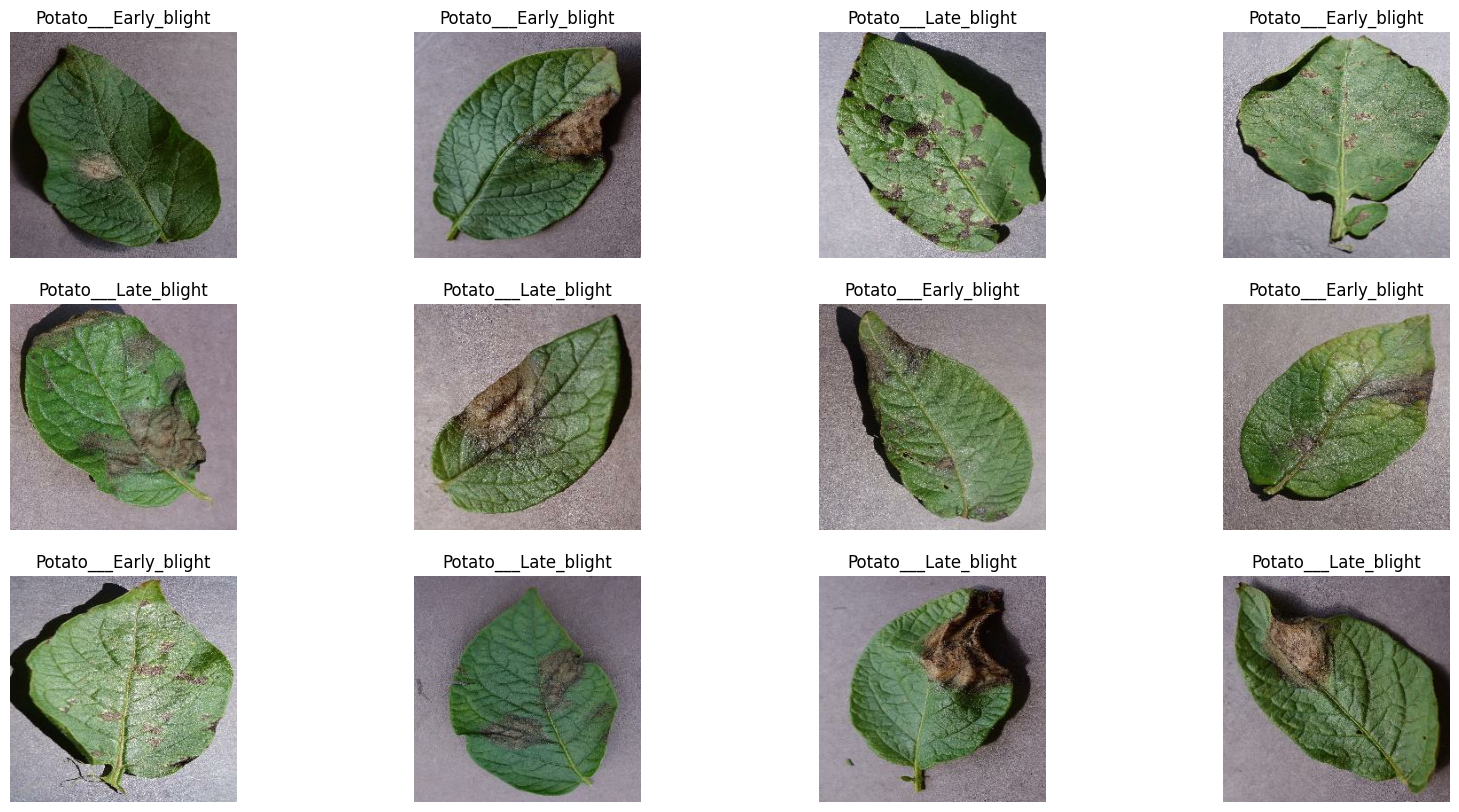

In [8]:
plt.figure(figsize=(20,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[labels_batch[i]])
        plt.axis('off')

In [9]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
        assert (train_split + test_split + val_split) == 1

        ds_size=len(ds)#68
        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
        train_size=int(train_split*ds_size)#0.8*68=54
        val_size=int(val_split*ds_size)#0.1*68=6
        train_ds = ds.take(train_size) #54
        val_ds = ds.skip(train_size).take(val_size)#it will skip 54 and take 6
        test_ds = ds.skip(train_size).skip(val_size)#it will skip 54 and skip  6 and take 8
        return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

54

In [12]:
len(test_ds)

8

In [13]:
len(val_ds)

6

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(Image_Size, Image_Size),
  layers.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [17]:
input_shape = (Image_Size, Image_Size, Channels)
batch_input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
n_classes=3

In [18]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

C:\Users\karth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=Batch_Size,
    validation_data=val_ds,
    verbose=1,
    epochs=Epochs,
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 841ms/step - accuracy: 0.4988 - loss: 0.9388 - val_accuracy: 0.6094 - val_loss: 0.8880
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 741ms/step - accuracy: 0.6913 - loss: 0.6982 - val_accuracy: 0.8385 - val_loss: 0.4425
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 51s 944ms/step - accuracy: 0.8072 - loss: 0.4378 - val_accuracy: 0.8594 - val_loss: 0.3271
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 757ms/step - accuracy: 0.8793 - loss: 0.3045 - val_accuracy: 0.8802 - val_loss: 0.2801
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 819ms/step - accuracy: 0.8979 - loss: 0.2582 - val_accuracy: 0.8802 - val_loss: 0.2584
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 692ms/step - accuracy: 0.9110 - loss: 0.2403 - val_accuracy: 0.8594 - val_loss: 0.3304
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 667ms/step - accuracy: 0.9374 - loss: 0.1751 - val_accuracy: 0.9062 - val_loss: 0.2333
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 660ms/step - accuracy: 0.9312 - loss: 0.1585 - val_accu

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(Epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_name[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [ ]:
model.save("trained_model.keras")